Abbreviations of morphological classes used in folder structure and annotation file
----------------------------------------------------------------------------------------
**BAS** Basophil

**EBO** Erythroblast (and Monoblast)

**EOS** Eosinophil

**LYT** Lymphocyte (typical and atypical)

**MON** Monocyte

**MYO** Myeloblast (Metamyelocyte and Myelocyte)

**NGB** Neutrophil (band)

**NGS** Neutrophil (segmented)

**PMO** Promyelocyte (bilobled and not)

**Подготовка набора данных**

In [1]:
import os
import shutil
from dataset_preparing import create_labels, tiff_to_png 

In [2]:
labels = {'BAS': 1, 'EBO': 2, 'MON': 3, 'LYT': 4, 'EOS': 5, 'MYO': 6, 'NGB': 7, 'NGS': 8, 'PMO': 9}
cur_path = os.getcwd()

In [ ]:
# Конвертируем .tiff в .png
tiff_to_png(path=f'{cur_path}\images_tiff', out=f'{cur_path}\images_png\\')

In [4]:
# Разделяем test и train выборки по соответствующим директориям
# 80% на train и 20% на test

for folder, _, files in os.walk(f'{cur_path}\images_png'):
    file_counter = 0
    for file in files:
        # Делим набор данных
        if file_counter % 5 == 0:
            shutil.copy(src=os.path.join(folder, file),
                        dst=f'dataset\\test\{file}')
        else:
            shutil.copy(src=os.path.join(folder, file),
                        dst=f'dataset\\train\{file}')
        file_counter+=1

In [3]:
# Создаём метки классов в формате csv для каждого изображения в test и train 

train_path = f'{cur_path}\\dataset\\train'
test_path = f'{cur_path}\\dataset\\test'

create_labels(path=train_path, labels=labels, csv_path=train_path + '.csv')
create_labels(path=test_path, labels=labels, csv_path=test_path + '.csv')

In [1]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
import dataloader as dl

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
import numpy as np

In [5]:
batch_size = 4
learning_rate = 1e-3
num_epochs = 20
num_classes = 9

In [6]:
# Use transforms.compose method to reformat images for modeling,
# and save to variable all_transforms for later use
all_transforms = transforms.Compose([dl.Rescale((256, 256)),
                                     dl.ToTensor()
                                     ])

train_dataset = dl.LeukocytesDataset(root_dir='dataset/train',
                                    csv_file='dataset/train.csv',
                                    train=True,
                                    transform=all_transforms
                                    )

test_dataset = dl.LeukocytesDataset(root_dir='dataset/test',
                                    csv_file='dataset/test.csv',
                                    transform=all_transforms,
                                    train=False
                                    )

# Instantiate loader objects to facilitate processing
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [ ]:
def show_landmarks(self, idx):
    """Show image with landmarks"""
    img_name = os.path.join(self.root_dir,
                            self.landmarks_frame.iloc[idx, 0])
    plt.title(self.landmarks_frame.iloc[idx, 1])
    plt.imshow(io.imread(img_name))

In [7]:
test_dataset.__getitem__(172)

9


{'image': tensor([[[0.8910, 0.8930, 0.8817,  ..., 0.7574, 0.7432, 0.7407],
          [0.8869, 0.8869, 0.8820,  ..., 0.7928, 0.7657, 0.7333],
          [0.8811, 0.8859, 0.8842,  ..., 0.8344, 0.7993, 0.7618],
          ...,
          [0.8691, 0.8602, 0.8635,  ..., 0.7206, 0.7679, 0.8286],
          [0.8745, 0.8704, 0.8661,  ..., 0.7326, 0.7770, 0.8381],
          [0.8728, 0.8688, 0.8791,  ..., 0.7406, 0.7958, 0.8486]],
 
         [[0.8753, 0.8707, 0.8568,  ..., 0.6924, 0.6674, 0.6562],
          [0.8712, 0.8646, 0.8537,  ..., 0.7413, 0.7054, 0.6683],
          [0.8655, 0.8663, 0.8579,  ..., 0.8027, 0.7602, 0.7188],
          ...,
          [0.8504, 0.8477, 0.8572,  ..., 0.6296, 0.7049, 0.8000],
          [0.8386, 0.8496, 0.8614,  ..., 0.6494, 0.7248, 0.8095],
          [0.8397, 0.8508, 0.8721,  ..., 0.6800, 0.7583, 0.8244]],
 
         [[0.8736, 0.8723, 0.8595,  ..., 0.7990, 0.7749, 0.7479],
          [0.8751, 0.8718, 0.8631,  ..., 0.8649, 0.8246, 0.7730],
          [0.8694, 0.8722, 0.86

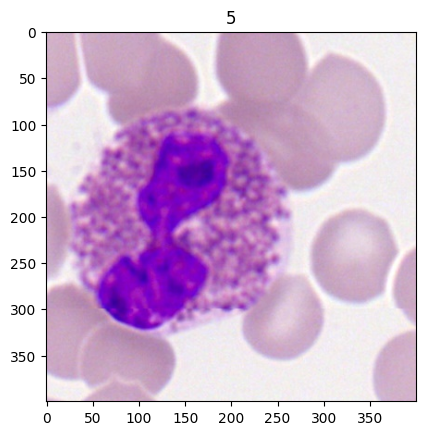

In [8]:
train_dataset.show_landmarks(154)

In [10]:
import torch.nn.functional as F

In [11]:
class LeukocytesCNN(nn.Module):
    def __init__(self):
        super(LeukocytesCNN, self).__init__()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5)

        self.fc1 = nn.Linear(3 * 3 * 128, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

        def forward(self, x):
            out = self.conv1(x)
            out = self.conv2(out)
            out = self.pool(out)

            out = self.conv3(out)
            out = self.conv4(out)
            out = self.pool(out)
            # x = self.pool(F.relu(self.conv1(x)))
            # x = self.pool(F.relu(self.conv2(x)))
            # x = self.pool(F.relu(self.conv3(x)))

            print(x.shape)

            x = x.view(-1, 3 * 3 * 128)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.sigmoid(self.fc3(x))
            return out

In [12]:
from tqdm.notebook import tqdm

In [13]:
net = LeukocytesCNN()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [14]:
epochs = tqdm(range(num_epochs))

for epoch in epochs:
    running_loss = 0
    for i, batch in enumerate(tqdm(train_loader)):
        X_batch, y_batch = batch # получение текущего batch
        optimizer.zero_grad() # обнуляем градиент

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() # текущий loss

        epochs.set_postfix({'loss: {running_loss}'})

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

ValueError: cannot reshape array of size 1 into shape (2)